# Expirements - Collaborative Filtering (Ridge ALS, Implicit ALS, NCF)

The base model will be a simple collaborative filtering system based on the interractions matrix

Table of content:
- [Baseline Model - User based Nearest Neighbor]( #User-Based-Collaborative-Filtering---Base-Model)
- [Ridge ALS (Alternative Least Square) - Matrix Factorization]( #Matrix-Factorization-with-Ridge-ALS---Collaborative-Filtering)
- [Implicit ALS (Alternative Least Square) - Matrix Factorization]( #Matrix-Factorization-with-Implicit-ALS---Collaborative-Filtering)
- [NCF (Neural Collaborative Filtering)]( #Matrix-Factorization-with-Implicit-ALS---Collaborative-Filtering)

Learns latent representations from the interaction matrix:

* **User Features**: Not Used

* **Item Features**: Not Used

* **Interaction Features**: Feedbacks (watch ratio)

* **Temporal Features**: Not Used

### Imports

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from typing import Dict, List, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity
import random
from collections import defaultdict
import math

from random_utils import set_seed
from model_utils import normalize_ratings

set_seed(45)

plt.rcParams["figure.figsize"] = (20, 13)
colors = plt.get_cmap('tab10').colors
plt.rc('axes', prop_cycle=cycler('color', colors))

%matplotlib inline
%config InlineBackend.figure_format = "retina"

2025-05-04 16:33:58.714398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746376438.925141     225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746376439.001013     225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746376439.436421     225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746376439.436479     225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746376439.436484     225 computation_placer.cc:177] computation placer alr

### Loading Datasets

In [3]:
interactions_train = pd.read_csv("../data_final_project/KuaiRec 2.0/data/big_matrix.csv")
interactions_train

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000
...,...,...,...,...,...,...,...,...
12530801,7175,1281,34618,140017,2020-09-05 15:07:10.576,20200905,1.599290e+09,0.247241
12530802,7175,3407,12619,21888,2020-09-05 15:08:45.228,20200905,1.599290e+09,0.576526
12530803,7175,10360,2407,7067,2020-09-05 19:10:29.041,20200905,1.599304e+09,0.340597
12530804,7175,10360,6455,7067,2020-09-05 19:10:36.995,20200905,1.599304e+09,0.913400


In [4]:
interactions_test = pd.read_csv("../data_final_project/KuaiRec 2.0/data/small_matrix.csv")
interactions_test

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364
...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,NaN,NaN,NaN,2.178160
4676566,7162,2065,11919,6067,NaN,NaN,NaN,1.964562
4676567,7162,1296,16690,19870,NaN,NaN,NaN,0.839960
4676568,7162,4822,11862,24400,NaN,NaN,NaN,0.486148


### Preprocessing

In [5]:
def preprocess(data):
    data.drop_duplicates(['user_id', 'video_id'], keep='first', inplace=True)
    data.drop(columns=['play_duration', 'video_duration', 'time', 'date', 'timestamp'])
    return data.pivot(index='user_id', columns='video_id', values='watch_ratio')

data_preprocessed = preprocess(interactions_train)
test_data_preprocessed = preprocess(interactions_test)

In [6]:
test_data_preprocessed

video_id,103,109,120,122,128,130,131,133,136,137,...,10430,10436,10457,10462,10500,10506,10519,10552,10589,10595
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.429126,1.482039,0.728738,0.477810,0.439333,1.150245,1.816317,0.781122,1.554396,2.307486,...,0.348932,0.965220,1.787169,1.816010,0.150323,1.535256,2.757278,0.143556,1.273362,1.719201
19,0.624466,1.070684,1.006064,0.759092,0.882691,0.639313,0.670019,1.407319,0.874814,0.722665,...,0.642896,0.633833,0.586222,1.178295,NaN,0.977297,1.266322,0.265038,0.928168,1.107873
21,1.415049,1.028840,1.809125,0.688823,0.588365,0.619549,0.818749,1.944596,1.015039,0.575723,...,0.896847,0.918930,0.602573,0.995887,1.173871,0.957399,1.148837,0.216699,1.210398,1.713792
23,0.169223,2.549891,0.247487,0.438669,0.114338,0.828292,0.038440,2.455882,1.128438,1.021400,...,0.577134,0.335534,5.304503,0.610346,0.185161,4.725427,0.338674,0.430445,2.225363,NaN
24,0.345049,0.449337,0.802936,0.797411,1.875599,0.783867,2.104939,6.418434,0.228018,3.892566,...,0.884743,0.578658,0.300125,2.151558,2.311935,1.848424,0.388630,0.103633,0.547944,0.093900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,0.575631,0.960989,0.950854,0.611157,0.569484,0.944994,0.481794,1.020178,0.805988,0.514642,...,0.727006,0.794809,0.843906,1.491536,1.525323,1.261752,1.630146,0.300578,1.047888,1.419171
7147,1.112427,0.380971,1.419818,0.617423,1.067951,1.020166,0.925878,1.656635,0.907465,0.722232,...,0.541901,0.813574,1.014475,1.575067,1.614839,1.191774,1.935745,0.261799,0.974836,1.364633
7153,1.338544,0.414703,0.664433,0.339429,1.038049,0.225616,0.425432,2.330027,2.045522,0.604141,...,0.568422,0.887281,0.287259,4.364816,0.898387,0.944044,1.031352,0.309217,0.723977,0.425931


In [7]:
data_preprocessed

video_id,0,1,2,3,4,5,6,7,8,9,...,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.452116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ground Truth

In [7]:
from model_utils import build_ground_truth_at_least_once, build_ground_truth_at_least_once_entirely, build_ground_truth_mean

train_ground_truth = build_ground_truth_at_least_once(data_preprocessed)
test_ground_truth = build_ground_truth_at_least_once(test_data_preprocessed)

### Item Popularity

In [ ]:
## Some performance issues computing popularity
"""
def melt_sparse(df):
    df_sparse = df.astype(pd.SparseDtype("float", fill_value=0))
    df_long = df_sparse.reset_index().melt(
        id_vars='user_id', 
        var_name='video_id', 
        value_name='watch_ratio'
    )
    return df_long[df_long['watch_ratio'] > 1e-3]

train_long = melt_sparse(data_preprocessed)
test_long = melt_sparse(test_data_preprocessed)

combined_long = pd.concat([train_long, test_long], axis=0, ignore_index=True)\
                  .drop_duplicates(subset=['user_id', 'video_id'], keep='first')

combined_long_sparse = combined_long.pivot(index='user_id', columns='video_id', values='watch_ratio')\
                                    .astype(pd.SparseDtype("float", fill_value=0))

item_popularity = (combined_long_sparse > 1e-3).sum(axis=0) / len(combined_long_sparse)
item_popularity
"""

## User based Nearest Neighbor - Base Model

The base model will simply get all interactions from all users (that has watched the video) and recommend the video that their similar user watched

User's similarity will be computed from interaction matrix and be used to weighten recommended videos

<div style="text-align: center;">
  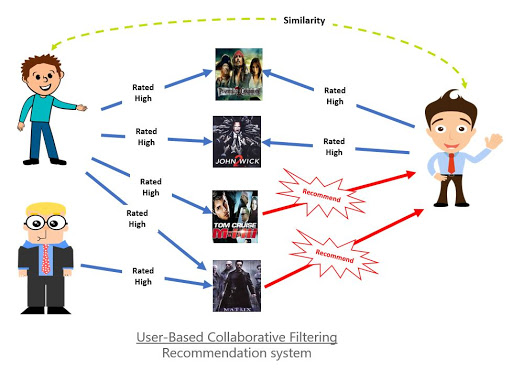
</div>

### Model

In [13]:
class CollaborativeFiltering:
    def __init__(self):
        self.user_similarity = None
        self.user_item_matrix = None
        self._prediction_cache = {}  # Internal cache for user predictions

    def fit(self, data):
        self.user_item_matrix = data.fillna(0)
        self.user_similarity = pd.DataFrame(
            cosine_similarity(self.user_item_matrix),
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )

    def predict(self, user_id, top_n=5):
        if user_id not in self.user_item_matrix.index:
            print(f"user {user_id} not found, cold start not inferred")
            return []

        similar_users = self.user_similarity[user_id].drop(user_id).sort_values(ascending=False)

        weighted_scores = pd.Series(dtype=np.float64)
        for sim_user, sim_score in similar_users.items():
            user_videos = self.user_item_matrix.loc[sim_user]
            weighted_scores = weighted_scores.add(user_videos * sim_score, fill_value=0)

        pred = weighted_scores.sort_values(ascending=False).head(top_n).index.tolist()
        self._prediction_cache[user_id] = pred  # Cache the prediction
        return pred


In [14]:
baseline_cf_model = CollaborativeFiltering()
baseline_cf_model.fit(data_preprocessed)
recommendations = baseline_cf_model.predict(user_id=14, top_n=10)
print(recommendations)

[3400, 10435, 1709, 7356, 2123, 314, 5434, 7812, 7383, 9130]


### Evaluation

In [15]:
K = 100
N_USERS = 10

#### Sampling recommendations and ground truth

In [17]:
# testing on some users
for user in [14, 19, 21, 23]:
    recommendations = baseline_cf_model.predict(user_id=user, top_n=K)
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(recommendations)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(recommendations)))} / {K} test recommendations in ground truth")

user 14: 100 / 100 train recommendations in ground truth
user 14: 48 / 100 test recommendations in ground truth
user 19: 100 / 100 train recommendations in ground truth
user 19: 43 / 100 test recommendations in ground truth
user 21: 99 / 100 train recommendations in ground truth
user 21: 44 / 100 test recommendations in ground truth
user 23: 100 / 100 train recommendations in ground truth
user 23: 59 / 100 test recommendations in ground truth


In [18]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
print(f"Selected users: {train_sample_user_ids}")
for user_id in train_sample_user_ids:
    train_sample_recommendations[user_id] = baseline_cf_model.predict(user_id=user_id, top_n=K)

train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
print(f"Selected users: {test_sample_user_ids}")
for user_id in test_sample_user_ids:
    test_sample_recommendations[user_id] = baseline_cf_model.predict(user_id=user_id, top_n=K)

test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

Selected users: [3912, 7051, 3755, 3023, 2776, 4699, 5212, 1345, 629, 6941, 6785, 5271, 2752, 115, 4087, 2305, 5091, 3274, 257, 2603, 4635, 5632, 6779, 6617, 850, 4894, 1934, 4330, 741, 235, 1953, 6593, 416, 1111, 5736, 2994, 4649, 418, 4817, 5929]
Selected users: [1647, 5864, 6396, 1443, 6684, 1042, 5772, 7147, 4546, 4986, 1514, 5600, 4756, 2318, 1187, 4891, 3569, 1199, 5692, 5008, 1773, 4419, 7135, 6540, 3506, 1022, 1725, 5524, 724, 6010, 2889, 1968, 5697, 3689, 5949, 4622, 1795, 2005, 2007, 6611]


#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [21]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

Training: k=100, users=40

NDCG100 = 0.9925981305207102
MAP@100 = 0.99225
MAR@100 = 0.009265064943806047
F1@100 = 0.018358706747975625
Testing: k=100, users=40

NDCG100 = 0.38438758945730167
MAP@100 = 0.4504999999999999
MAR@100 = 0.013594741225967238
F1@100 = 0.026393020123950346


#### Novelty

In [22]:
from metrics import novelty

novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

NameError: name 'item_popularity' is not defined

### Conclusion

The baseline model shows strong performance on the training set, with nearly perfect metrics: NDCG@100 and MAP@100 both at 0.99. However, we can clearly see an overfitting effect when evaluating on the testing set.

The large drop in NDCG and MAP on the test set suggests that the model memorized the training data rather than learning generalizable patterns.

The model is also very slow, that's why I am computing benchmark on only 40 randomly selected user.

To improve this model, we could try techniques like regularization or using more powerful models such as MF.

| Type    | k   | Users | NDCG@100   | MAP@100   | MAR@100   | F1@100    |
|----------|-----|--------|------------|-----------|-----------|-----------|
| Training | 100 | 40     | 0.990000   | 0.990000  | 0.009000  | 0.018000  |
| Testing  | 100 | 40     | 0.384388   | 0.450500  | 0.013595  | 0.026393  |

---


## Matrix Factorization with Ridge ALS - Collaborative Filtering

This is the Matrix Factorization approach using ALS algorithm and Ridge regularization - See [paper](https://ieeexplore.ieee.org/document/7888956/)

This collaborative filtering model uses ALS algorithm.

**Assumption**: we approximate the user-item matrix using matrix factorization into two embdeddings: $\hat{Y} \approx U^TV$

**Predictions**:

$$ Y = (U^T V)$$
- $U$ is a learned matrix representing user embeddings.
- $V$ is a learned matrix of representing item embeddings.

**Cost Function**:

$$ E_{RALS}(U, V) = || R \cdot (\hat{Y} - U^TV) ||^2 + \lambda_1 || U ||^2 + \lambda_2 || V ||^2 $$

$R$ is a binary matrix to filter out missing values

**Learning**:

From the paper, the derivative of the cost function on $U$ and $V$ is given by:

<center><img src="images/ALS_loss_derivative.png" style="width: 30%; height: auto;" /></center>

These are convex problem, global minima is found by zeroing the above equation. Thus we can find that at each step:

$$ V = (UU^T + \lambda_1 I)^{-1} U (R * \hat{Y}) $$

$$ U = (VV^T + \lambda_2 I)^{-1} V (R * \hat{Y})^T $$

$\lambda_n$ are hyperparameters, by default 1

### Model

In [15]:
class CollaborativeFilteringALS:
    def __init__(self):
        self.U = None
        self.V = None
        self.Y = None
        self.Ymean = None
        self.user_indices = None
        self.item_indices = None
        self.user_item_matrix = None
        self.losses = []

    def fit(self, data: pd.DataFrame, num_features=30, lambda1_=0.1, lambda2_=0.1,
            iterations=100, early_stopping=1e-3, reg=True, scale=0.2, normalization=False):

        R = (~data.isna()).astype(float).values
 
        self.user_item_matrix = data.copy()
        Y_hat = data.copy().fillna(0).values

        if normalization:
            Y_hat, self.Ymean = normalize_ratings(Y_hat, R)
        else:
            self.Ymean = np.zeros(Y_hat.shape[0])

        self.user_indices = data.index.values
        self.item_indices = data.columns.values

        num_users, num_items = Y_hat.shape
        # Initialize user factors matrix
        self.U = np.random.normal(loc=0.0, scale=scale, size=(num_features, num_users))
        self.V = None

        self.losses = []

        for i in range(iterations):
            # Update item factors
            if not reg:
                self.V = np.linalg.solve(
                    self.U @ self.U.T,
                    self.U @ Y_hat
                )
            else:
                self.V = np.linalg.solve(
                    self.U @ self.U.T + lambda1_ * np.eye(num_features),
                    self.U @ Y_hat
                )

            # Update user factors
            if not reg:
                self.U = np.linalg.solve(
                    self.V @ self.V.T,
                    self.V @ Y_hat.T
                )
            else:
                self.U = np.linalg.solve(
                    self.V @ self.V.T + lambda2_ * np.eye(num_features),
                    self.V @ Y_hat.T
                )

            # Predict ratings
            Y = np.zeros_like(Y_hat)
            for u in range(num_users):
                Y[u, :] = self.U[:, u].T @ self.V + self.Ymean[u]

            if np.isnan(Y).any():
                raise ValueError("NaNs detected in prediction matrix Y")

            # Calculate loss only on observed ratings
            loss = np.sum(np.square((Y_hat - Y) * R)) / np.sum(R)
            self.losses.append(loss)

            if i % 5 == 0:
                print(f"Iteration {i}: MSE loss = {loss:.4f}")
                print(f"Mean absolute error (watch ratio predicted gap) {(np.sum(np.abs((Y_hat - Y) * R)) / np.sum(R)):.4f}")

            if i >= 5 and np.all(np.abs(np.diff(self.losses[-5:])) < early_stopping):
                print(f"Early stopping at iteration {i}, recent losses: {self.losses[-5:]}")
                break

        return self

    def plot_loss(self, save=False, show=True, path=None):
        if not self.losses:
            print("No loss data to plot. Run `fit()` first.")
            return
        if save and not path:
            raise ValueError("Path must be specified if save=True")

        plt.figure(figsize=(8, 5))
        plt.plot(self.losses, label="Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss (MSE)")
        plt.title("Loss Over Iterations")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save:
            plt.savefig(path)
        if show:
            plt.show()

    def get_marks(self, user_ids=None):
        if user_ids is None:
            pred_matrix = np.zeros((len(self.user_indices), len(self.item_indices)))
            for u in range(len(self.user_indices)):
                pred_matrix[u, :] = self.U[:, u].T @ self.V + self.Ymean[u]
            return pred_matrix

        predictions = {}
        for user_id in user_ids:
            if user_id not in self.user_indices:
                print(f"User {user_id} not found in training data (cold start not handled).")
                predictions[user_id] = []
                continue

            user_idx = np.where(self.user_indices == user_id)[0][0]
            user_pred = self.U[:, user_idx].T @ self.V + self.Ymean[user_idx]
            predictions[user_id] = user_pred

        return predictions

    def predict(self, user_ids=None, top_n=5):
        marks = self.get_marks(user_ids)
        predictions = {}
        for user_id in user_ids:
            top_indices = np.argsort(marks[user_id])[-top_n:][::-1]
            recommended_items = [int(self.item_indices[i]) for i in top_indices]
            predictions[user_id] = recommended_items

        return predictions

#### Different hyperparams

Iteration 0: MSE loss = 2.9112
Iteration 5: MSE loss = 2.5337
Early stopping at iteration 9, recent losses: [np.float64(2.5337427547520726), np.float64(2.5327750727907254), np.float64(2.5323290345886007), np.float64(2.532127763678761), np.float64(2.5320465913144656)]
Iteration 0: MSE loss = 2.9125
Iteration 5: MSE loss = 2.5381
Iteration 10: MSE loss = 2.5353
Early stopping at iteration 10, recent losses: [np.float64(2.536835728654778), np.float64(2.5361466526004213), np.float64(2.5357417324129643), np.float64(2.535492997177822), np.float64(2.5353345055917527)]
Iteration 0: MSE loss = 2.7020
Iteration 5: MSE loss = 2.2437
Iteration 10: MSE loss = 2.2371
Early stopping at iteration 12, recent losses: [np.float64(2.2386258996192177), np.float64(2.2377702674326287), np.float64(2.237098686155867), np.float64(2.23656007203859), np.float64(2.236122379331131)]
Iteration 0: MSE loss = 2.3564
Iteration 5: MSE loss = 1.8167
Iteration 10: MSE loss = 1.8077
Early stopping at iteration 13, recent l

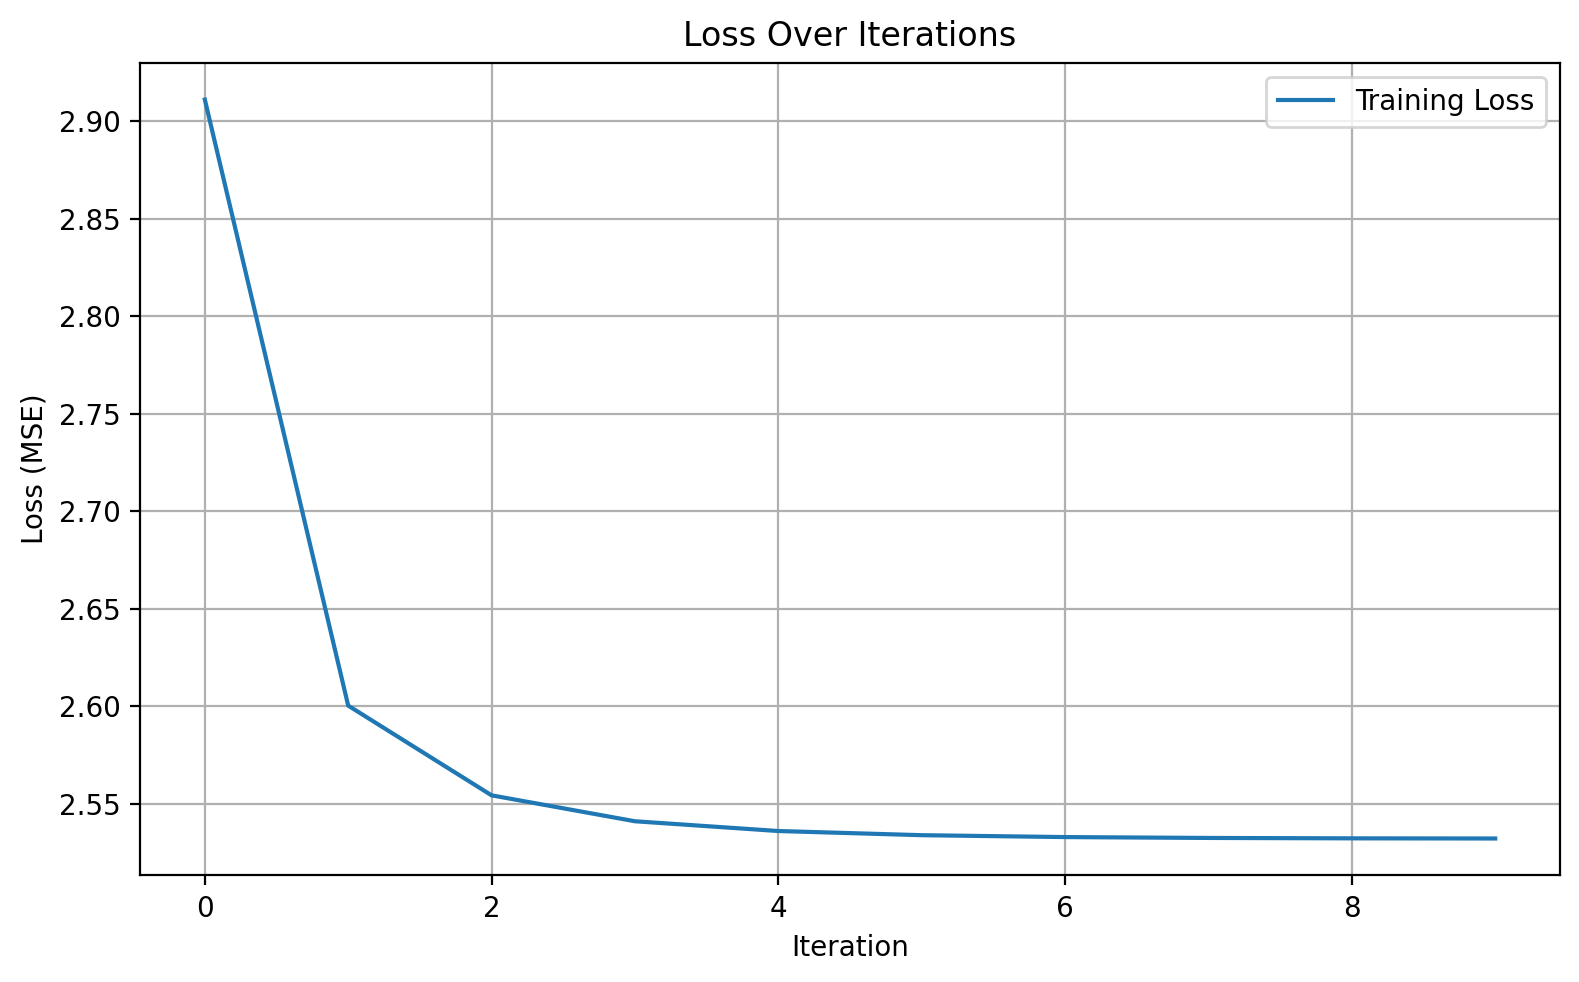

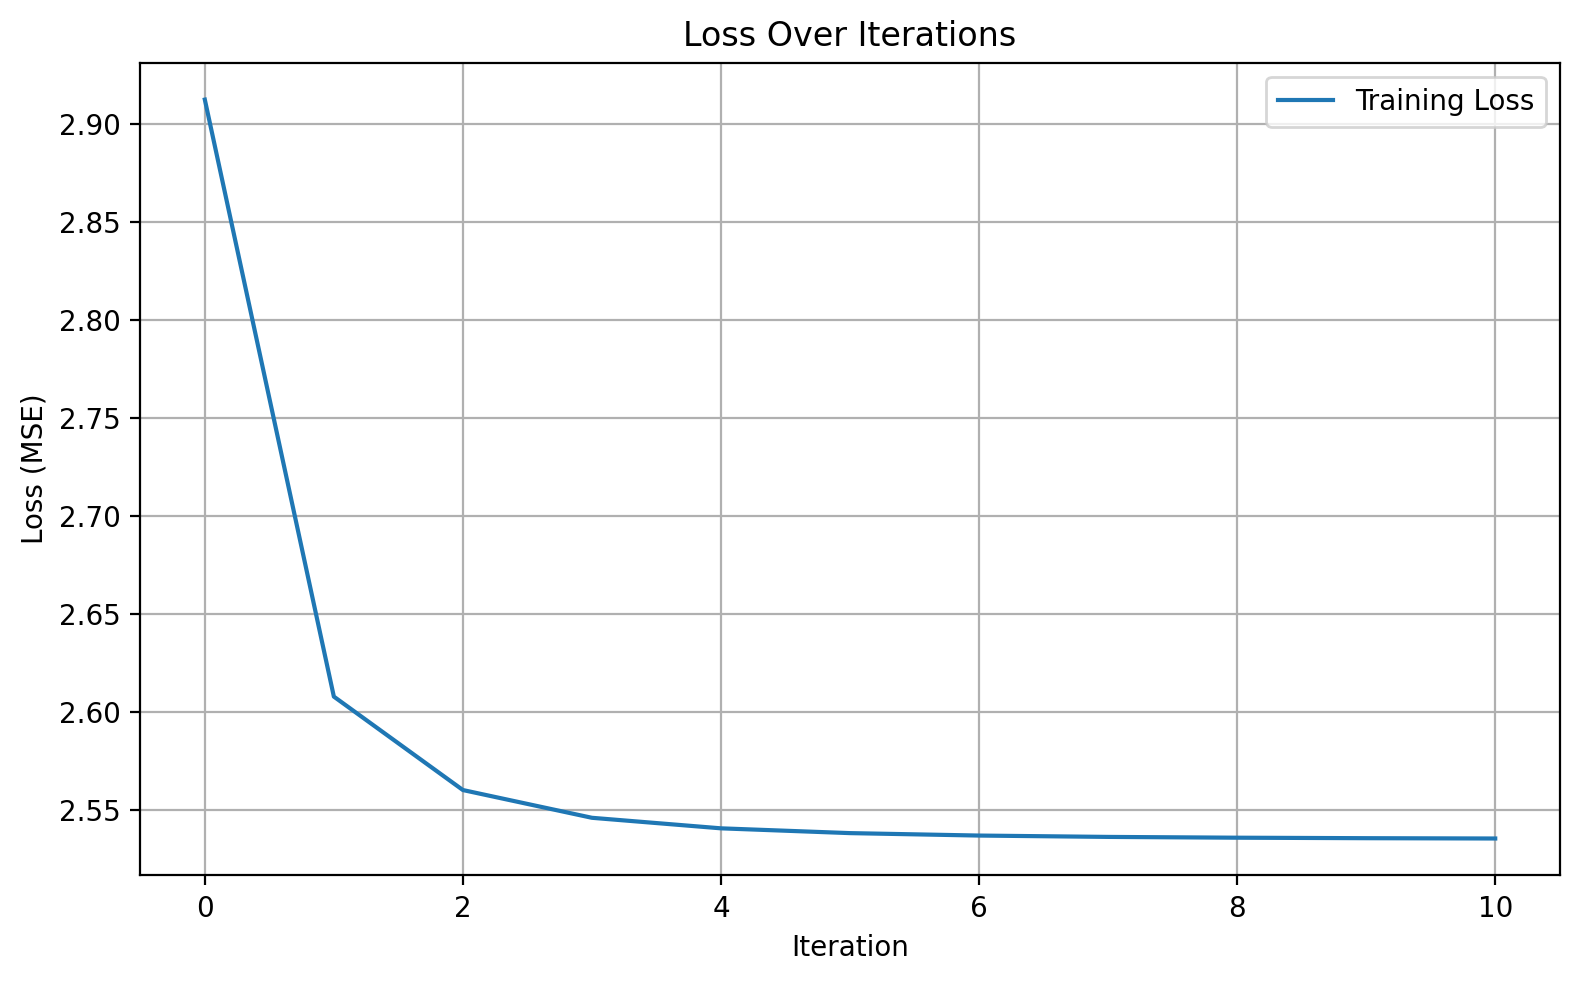

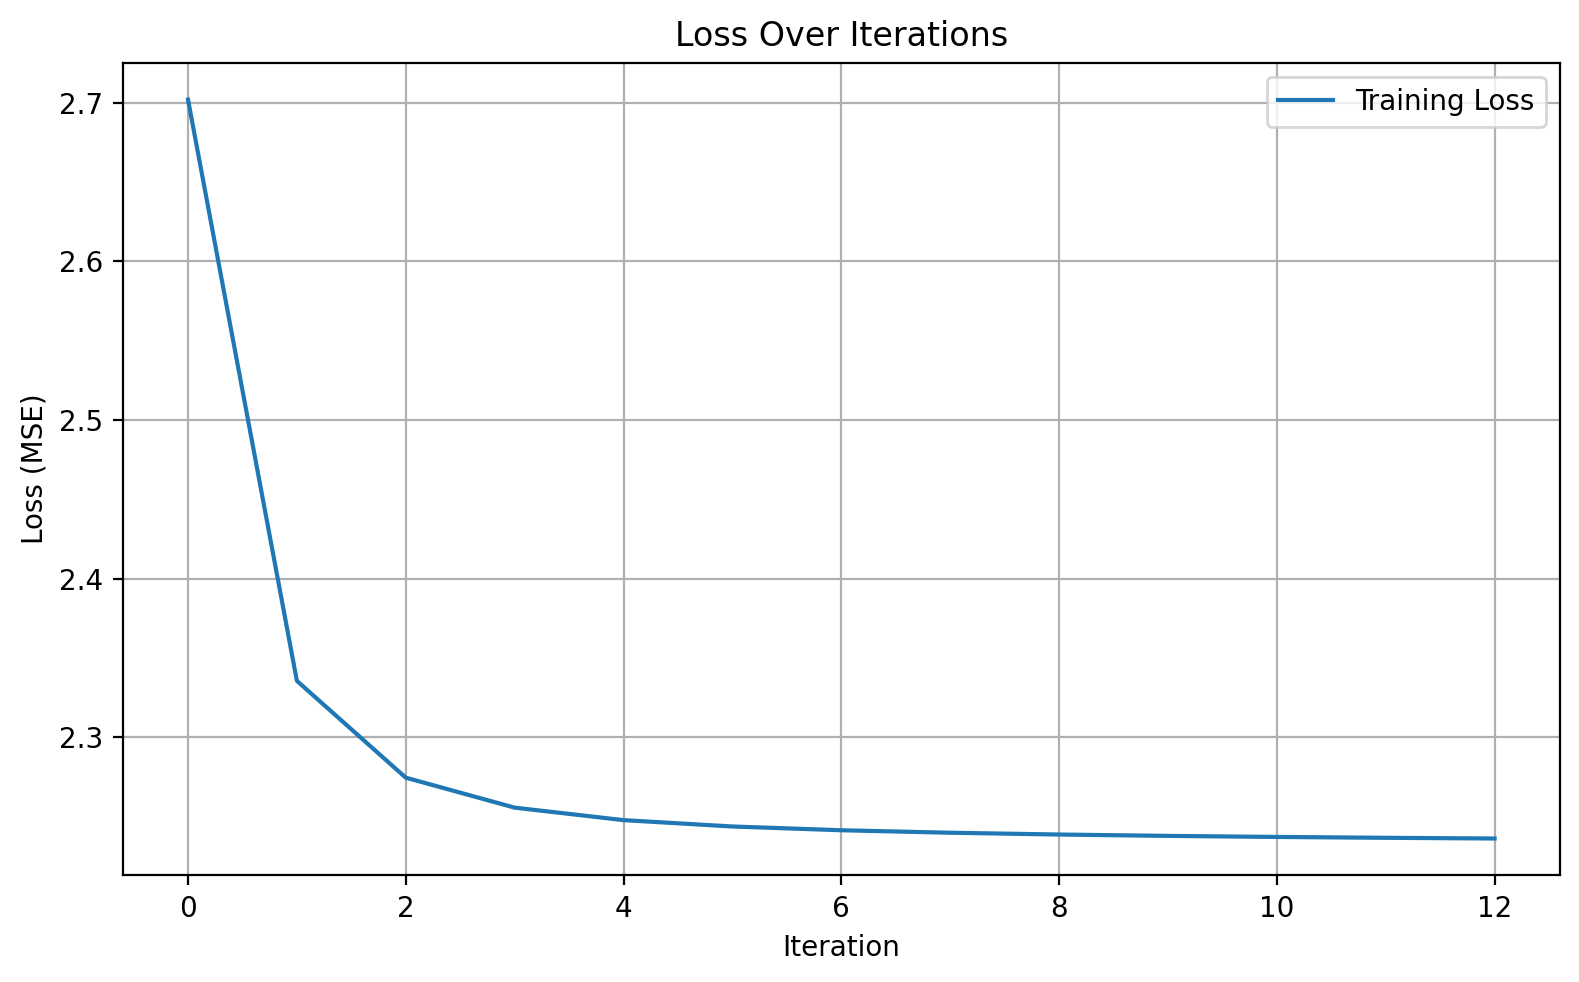

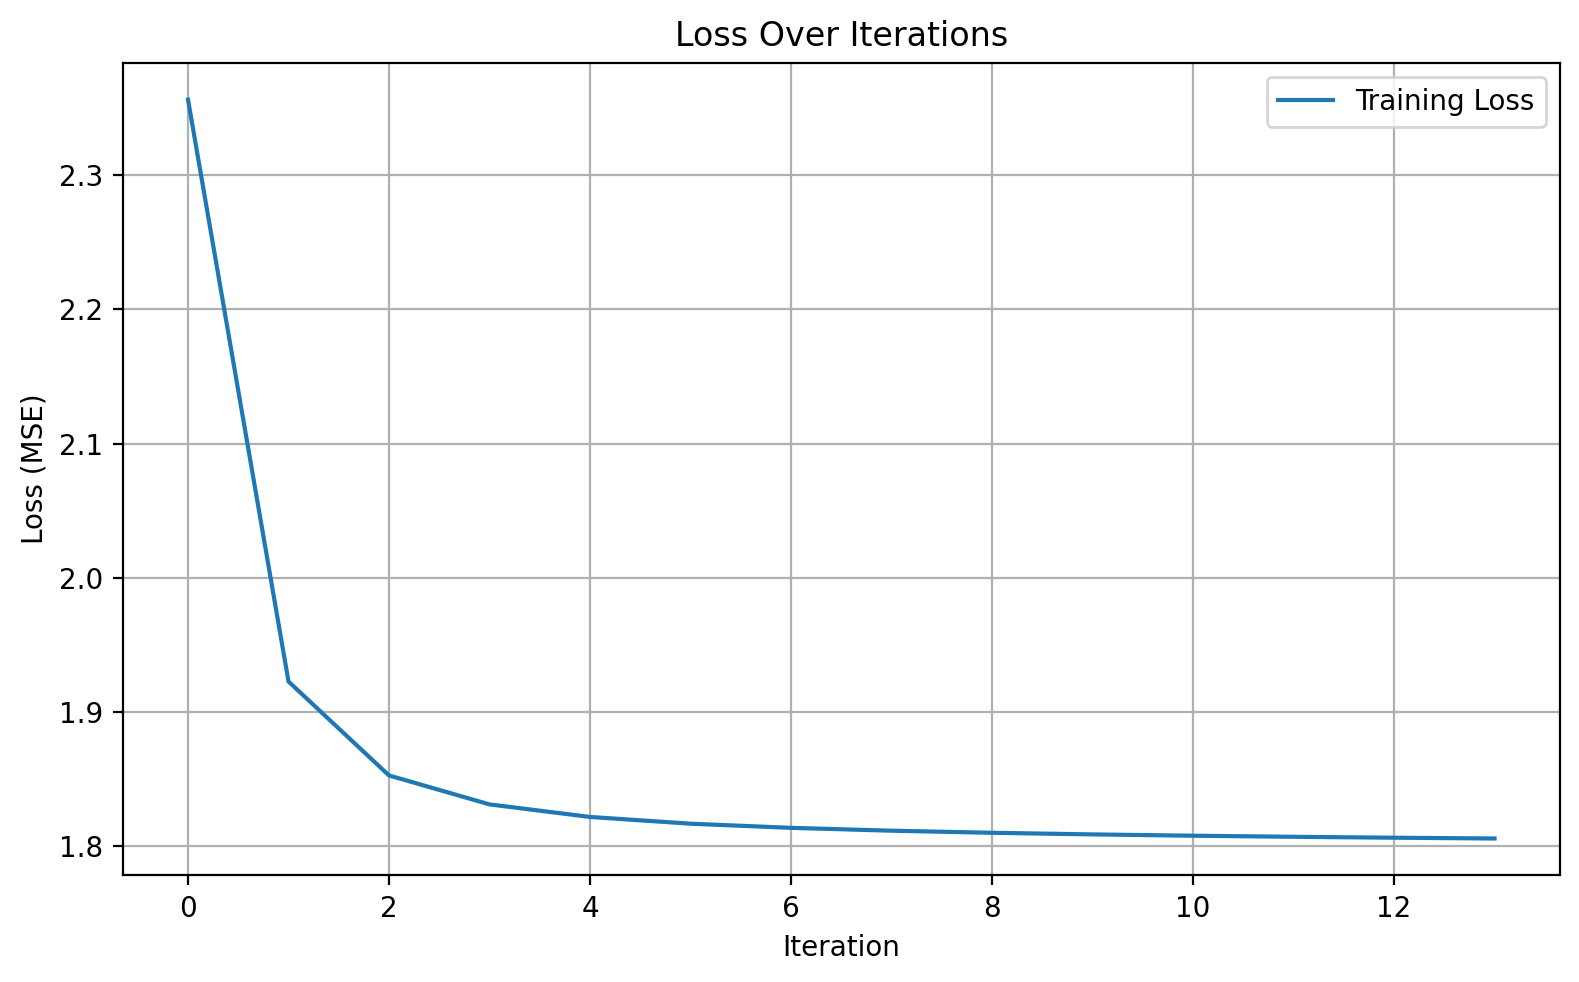

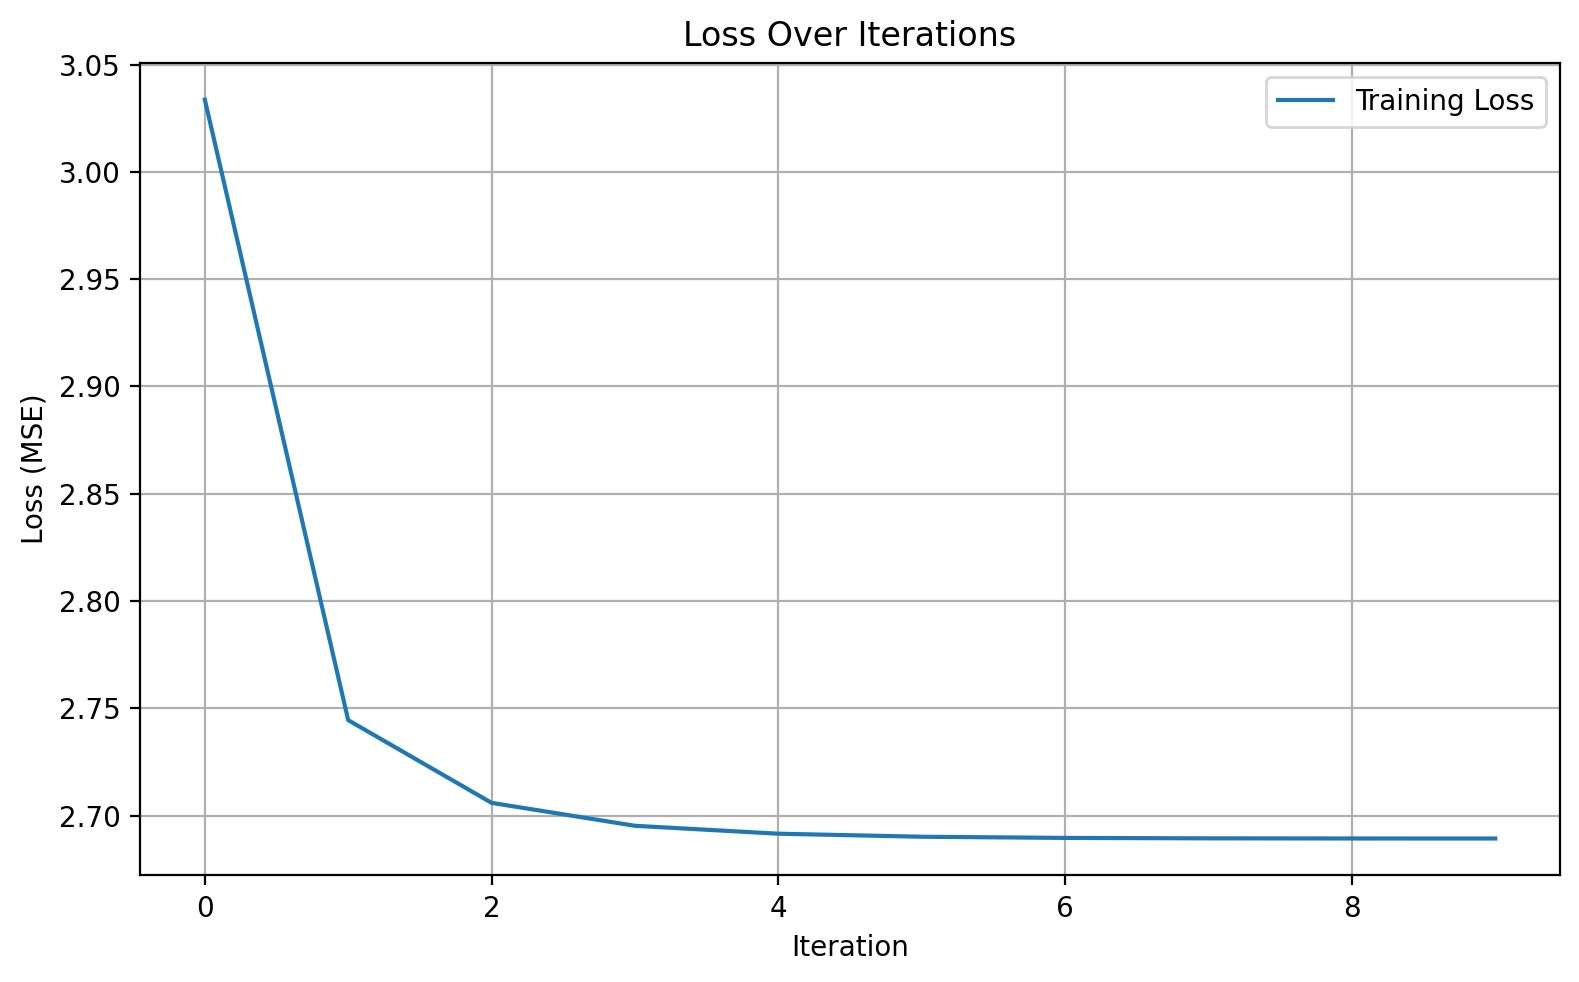

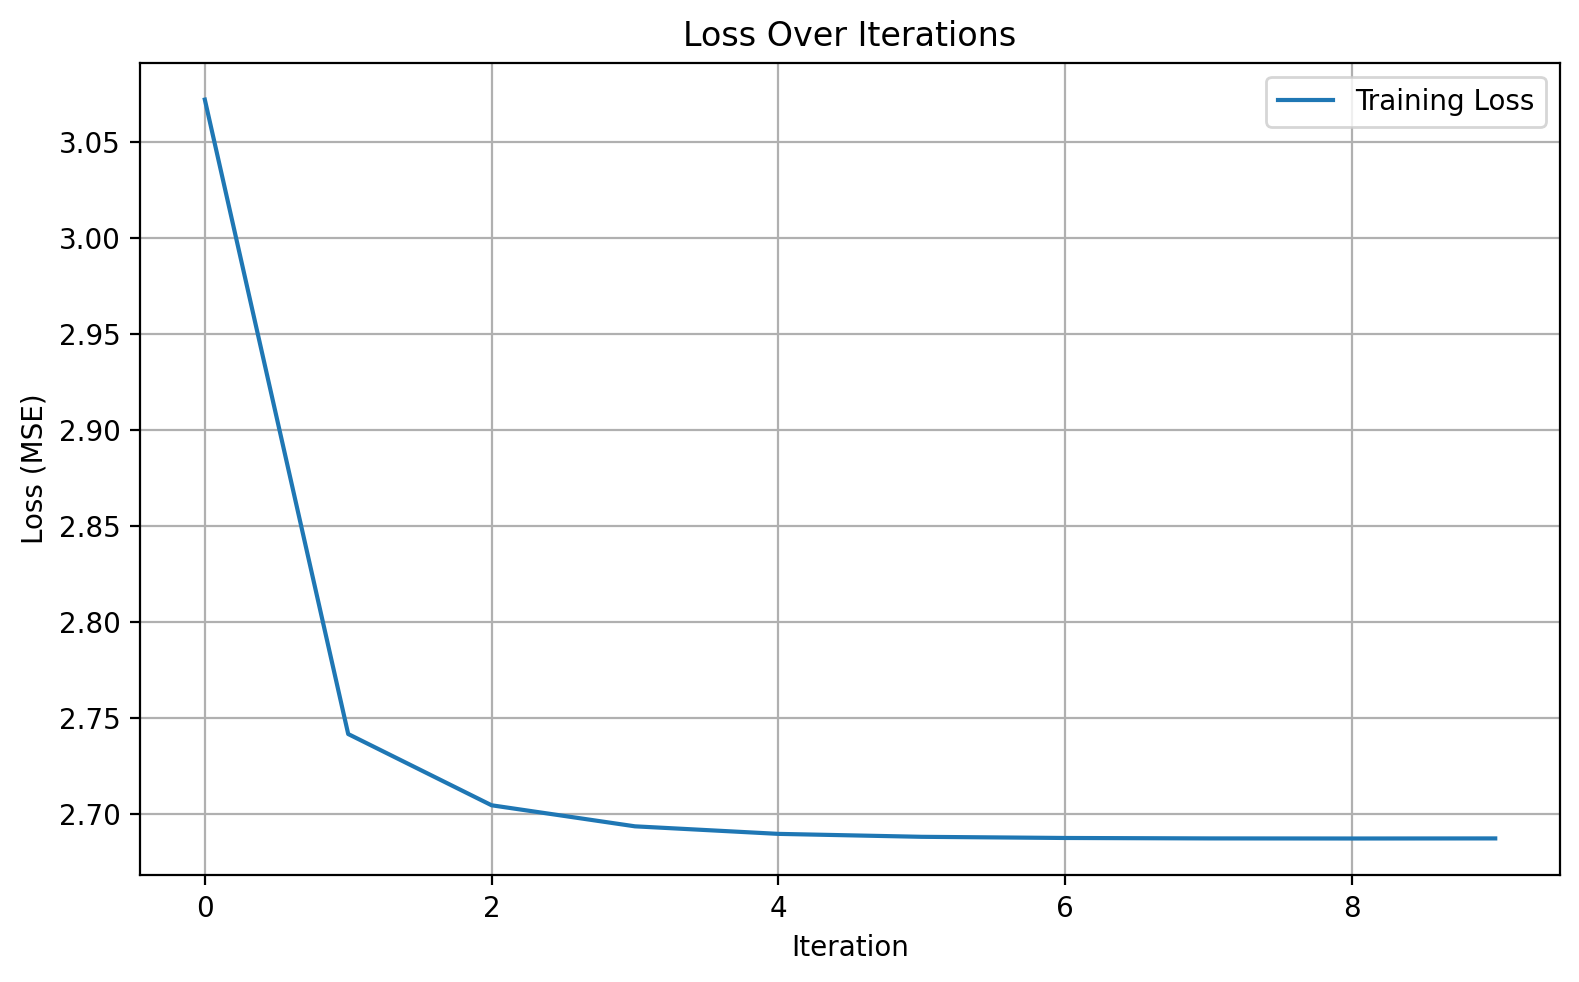

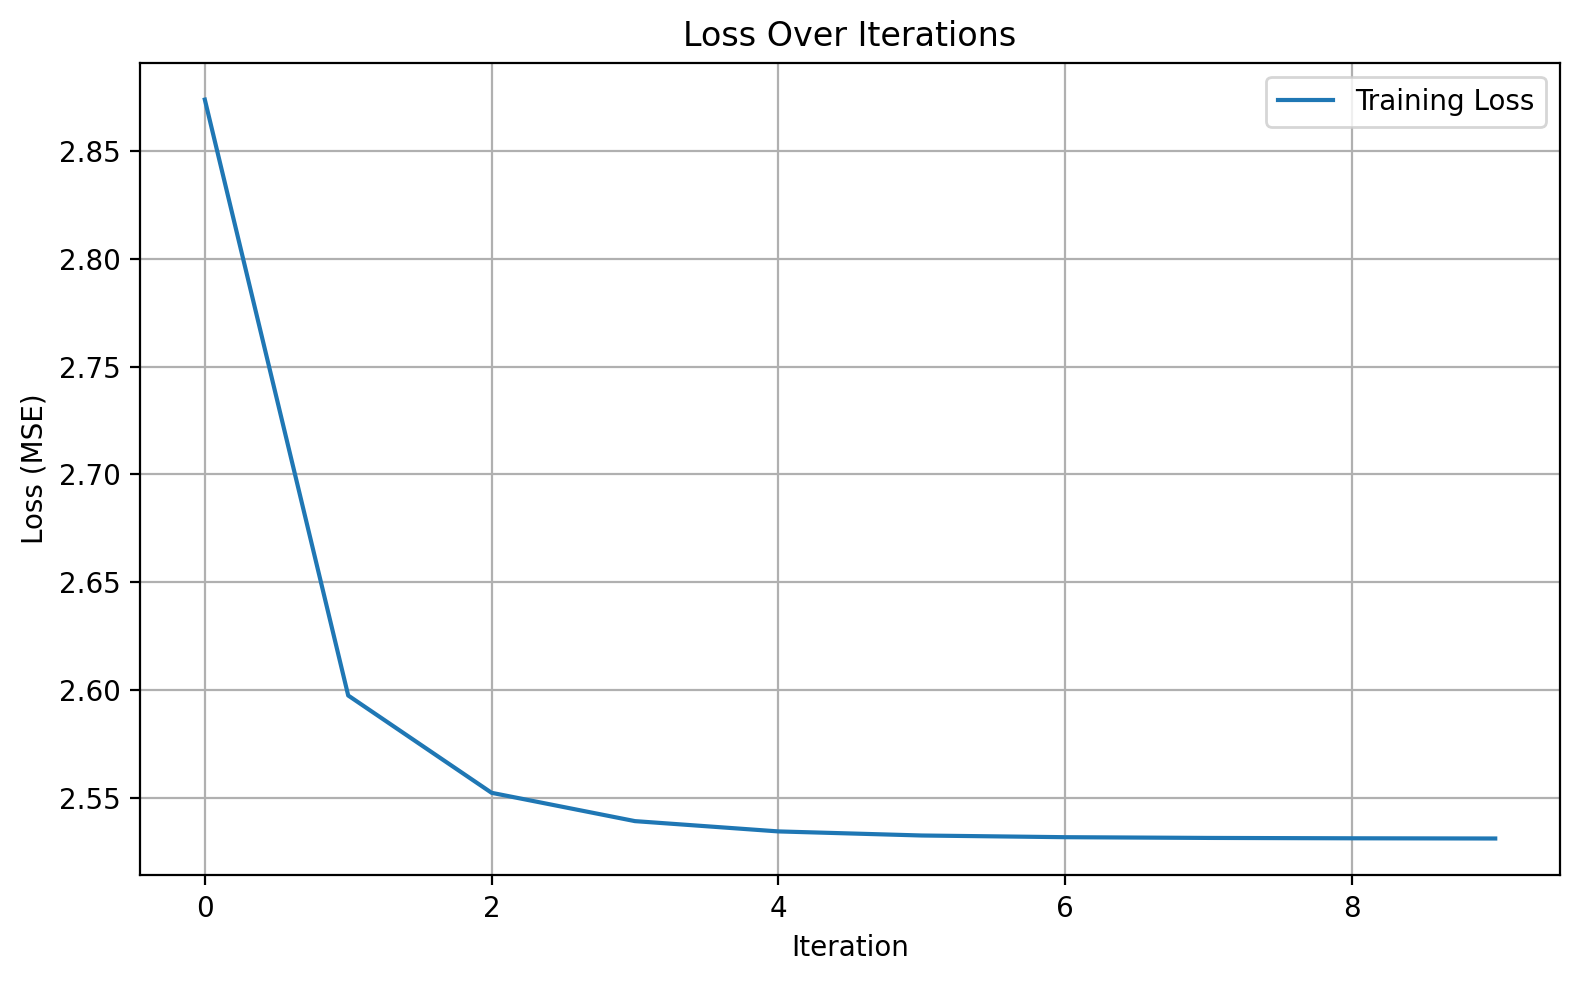

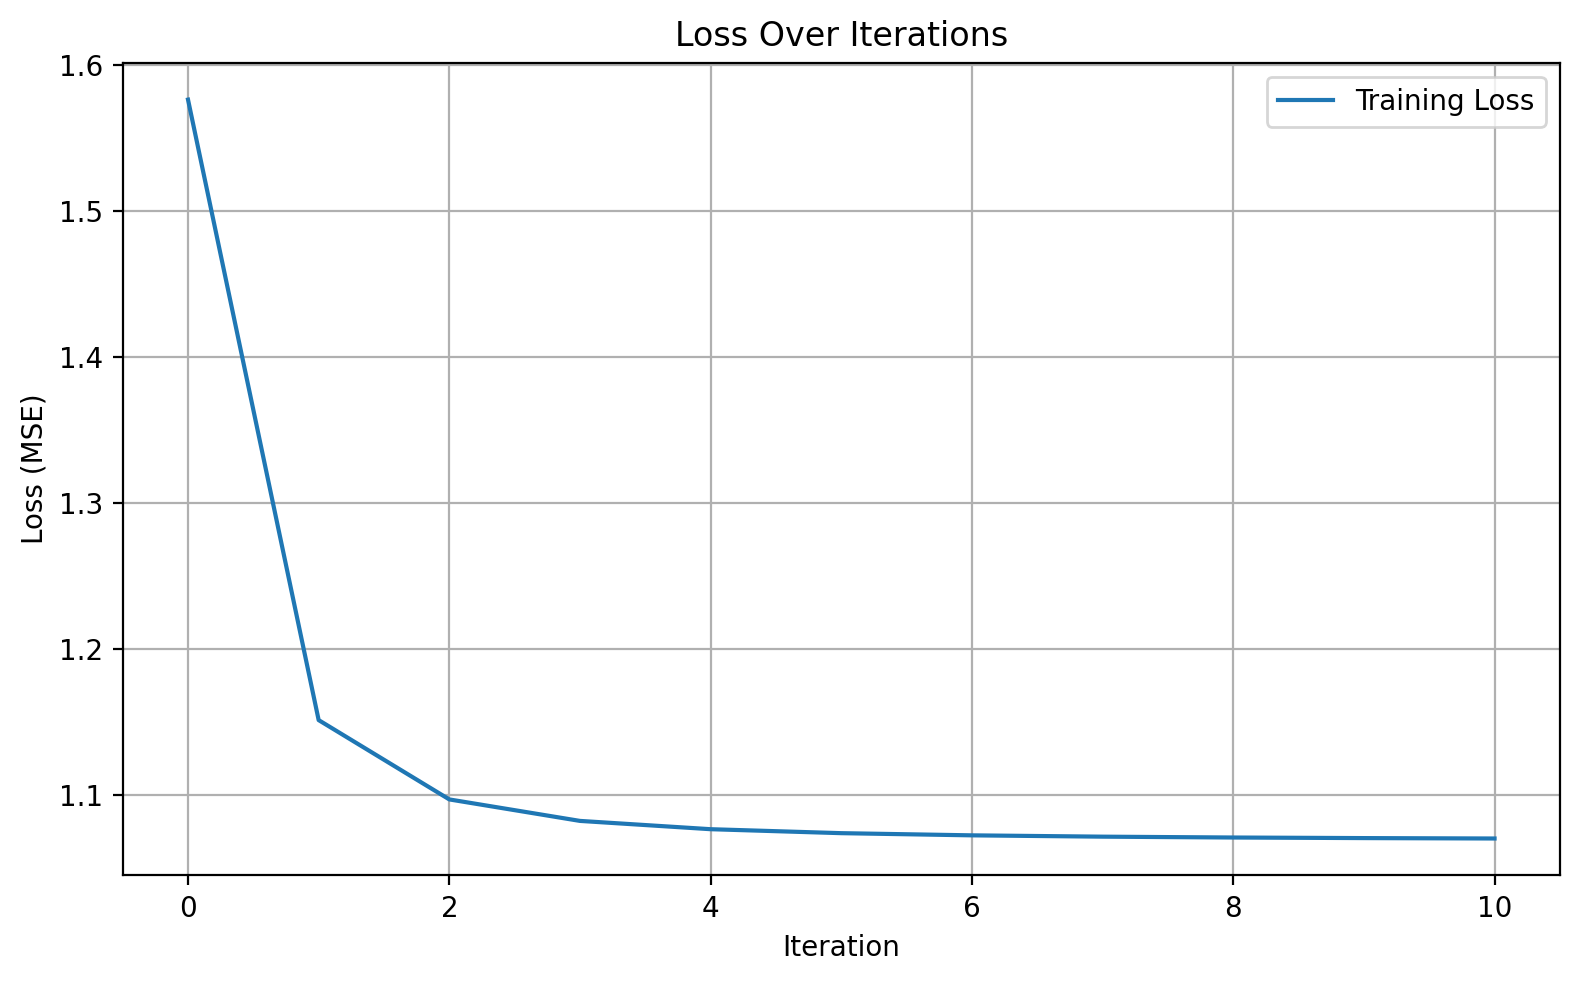

In [6]:
als_cf_model = CollaborativeFilteringALS()
for param in [
    {"num_feature": 50, "lambda": 1, "scale": 0.1},
    {"num_feature": 50, "lambda": 1, "scale": 0.2},
    {"num_feature": 100,  "lambda": 1, "scale": 0.3},
    {"num_feature": 200,  "lambda": 1, "scale": 0.3},
    {"num_feature": 30,  "lambda": 0.1, "scale": 0.2},
    # No reg
    {"num_feature": 30, "lambda": 0.0, "scale": 0.2},
    {"num_feature": 50, "lambda": 0.0, "scale": 0.5},
    {"num_feature": 500, "lambda": 0.0, "scale": 0.5},
]:
    print(f"Strating training with params: {param}")
    als_cf_model.fit(
        data_preprocessed,
        iterations=100,
        num_features=param["num_feature"],
        lambda1_=param["lambda"], lambda2_=param["lambda"],
        scale=param["scale"]
    )
    als_cf_model.plot_loss(save=True, show=False, path=f"images/ALS/ALS_scale{param["scale"]}_features{param["num_feature"]}_lambda{param["lambda"]}.png")

In [7]:
import os
from IPython.display import display, HTML
from pathlib import Path

plot_folder = Path("./images/ALS")
plot_files = sorted([f for f in plot_folder.glob("ALS_*.png")])

html_blocks = []
row = []

for i, plot in enumerate(plot_files):
    caption = plot.stem.replace("_", ", ").replace("ALS", "ALS:")
    block = f"""
    <figure style="text-align: center; width: 30%;">
        <img src="{plot.as_posix()}" style="width: 100%; height: auto;" />
        <figcaption>{caption}</figcaption>
    </figure>
    """
    row.append(block)

    # Group in rows of 3
    if (i + 1) % 3 == 0 or i == len(plot_files) - 1:
        row_html = f"""
        <div style="display: flex; justify-content: center; gap: 20px; flex-wrap: wrap;">
            {''.join(row)}
        </div>
        <br/>
        """
        html_blocks.append(row_html)
        row = []

display(HTML("".join(html_blocks)))

#### Best Model

Iteration 0: MSE loss = 3.4882
Mean absolute error (watch ratio predicted gap) 1.2097
Iteration 5: MSE loss = 3.2104
Mean absolute error (watch ratio predicted gap) 1.1926
Early stopping at iteration 9, recent losses: [np.float64(3.210380229316439), np.float64(3.209665810064176), np.float64(3.209428077897691), np.float64(3.209417200724772), np.float64(3.2095102533592694)]


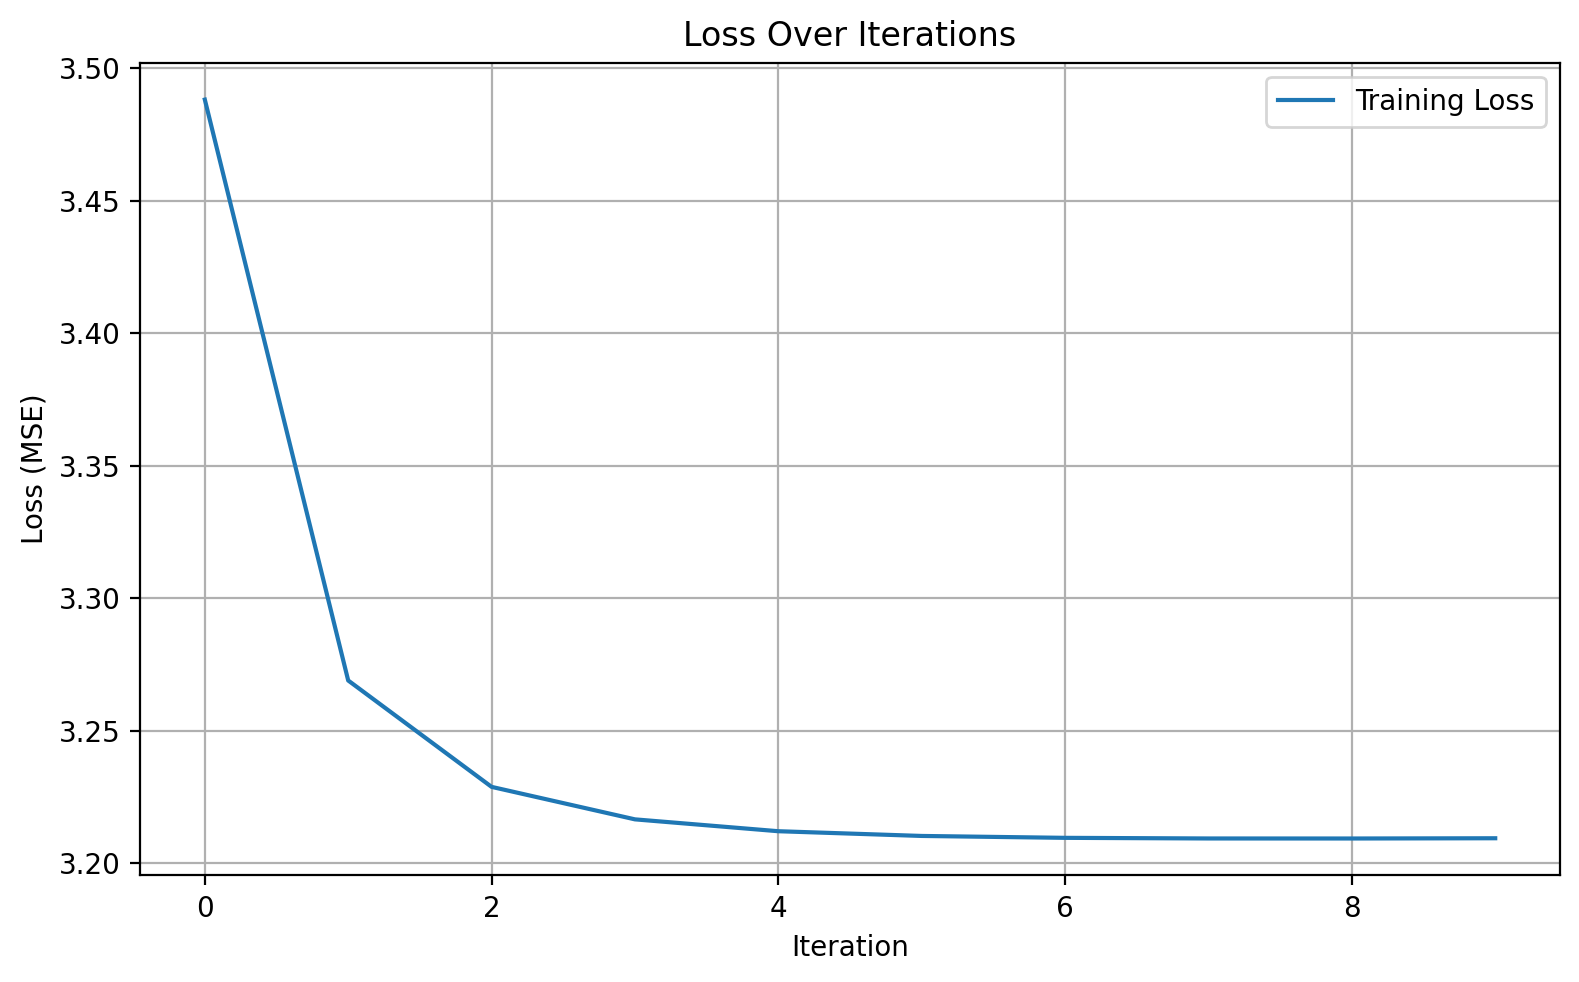

In [16]:
best_als_cf_model = CollaborativeFilteringALS()
best_als_cf_model.fit(
        data_preprocessed,
        iterations=100,
        num_features=50,
        lambda1_=1,
        lambda2_=1,
        scale=0.1,
        reg=True,
        normalization=True
)
best_als_cf_model.plot_loss()

In [17]:
recommendations = best_als_cf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

{14: [6309, 8305, 3400, 8435, 5510, 10017, 8743, 7077, 5434, 314]}


In [18]:
marks = best_als_cf_model.get_marks(user_ids=[14])
print(marks[14])

[1.07745793 1.07430163 1.07941926 ... 1.07730258 1.07749172 1.07756455]


In [19]:
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

1.0700093325213453
1.0792350158300896
1.0838034298112182
1.073375360069403


### Evaluation

In [20]:
K = 100
N_USERS = float('+inf')

#### Sampling recommendations and ground truth

In [21]:
# testing on some users
recommendations = best_als_cf_model.predict(user_ids=[14, 19, 21, 23], top_n=K)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {K} test recommendations in ground truth")

user 14: 100 / 100 train recommendations in ground truth
user 14: 56 / 100 test recommendations in ground truth
user 19: 100 / 100 train recommendations in ground truth
user 19: 37 / 100 test recommendations in ground truth
user 21: 100 / 100 train recommendations in ground truth
user 21: 42 / 100 test recommendations in ground truth
user 23: 100 / 100 train recommendations in ground truth
user 23: 93 / 100 test recommendations in ground truth


In [23]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
#print(f"Selected users: {train_sample_user_ids}")
train_sample_recommendations = best_als_cf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
#print(f"Selected users: {test_sample_user_ids}")
test_sample_recommendations = best_als_cf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

#### Bench Model (MAP@K, MAR@K, F1@K, NDCG@K)

In [25]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

Training: k=100, users=inf

NDCG@100 = 99.5064%
MAP@100 = 99.4625%
MAR@100 = 0.9290%
F1@100 = 1.8408%
Testing: k=100, users=inf

NDCG@100 = 42.8016%
MAP@100 = 45.9036%
MAR@100 = 1.3895%
F1@100 = 2.6973%


#### Novelty

In [ ]:
from metrics import novelty

novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

### Conclusion

The Ridge ALS model is fast to train and performs well on the training data, achieving high NDCG@100 and MAP@100 scores, similar to the baseline. 

However, the testing performance shows the same limitations: a noticeable drop in ranking metrics and very low recall.

| Type    | k   | Users | NDCG@100   | MAP@100   | MAR@100   | F1@100    |
|----------|-----|--------|------------|-----------|-----------|-----------|
| Training | 100 | All     | 0.995064   | 0.994625  | 0.009290  | 0.018408  |
| Testing  | 100 | All     | 0.428016   | 0.459036  | 0.013895  | 0.026973  |

While regularization in Ridge ALS helps reduce overfitting compared to the baseline, the model still struggles with missing interactions which reflects a drop in the meaningful metrics such as NDCG and MAP in test set.

To better handle the sparsity and implicit nature of video watch data, we should consider implicit feedback methods such as implicit matrix factorization. These models are specifically designed to treat missing entries not as zeros but as unknowns. This should lead to more robust generalization.

---

## Matrix Factorization with implicit ALS - Collaborative Filtering

The previous model struggles handling missing ratings. Another approach is using implicit ALS that is adapted for larg sparse matrix. 

This is the Matrix Factorization approach using implicit ALS algorithm and Ridge regularization - See [paper](https://www.academia.edu/download/37108248/2010_-_I._Pilaszy__D._Zibriczky__D._Tikk_-_ALS1.pdf)

There is some implementation [online](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe) as well (I find it dirty, I am not using it :) )

I changed the formula a little bit to adapt our case. We are not hanlding binary notation but rather a range between $0$ and $+\infty$

**Assumption**: Same as Ridge ALS

**Predictions**: No changes -> $ Y = (U^T V) $

**Cost Function**:

$$ E_{IALS}(U, V) = || C \cdot (\hat{Y} - U^TV) ||^2 + \lambda || U ||^2 + \lambda || V ||^2 $$

$C$ now is a weighted matrix. It gives more value on some specifc ratings (the 16% in our sparse training matrix)

Lambdas are the same, does not matter to be honest

**Learning**:

$$ V = (UCU^T + \lambda_1 I)^{-1} U (C * \hat{Y}) $$

$$ U = (VCV^T + \lambda_2 I)^{-1} V (C * \hat{Y})^T $$


### Model

In [6]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

class CollaborativeFilteringImplicitALS:
    def __init__(self):
        self.model = None

    def fit(self, data: pd.DataFrame, num_features=100, lambda_=1, iterations=25, alpha=50, random_state=None):
        self.user_item_matrix = data.fillna(0)
        self.user_indices = data.index.values
        self.item_indices = data.columns.values

        item_user_matrix = csr_matrix(self.user_item_matrix.values.T)

        self.model = AlternatingLeastSquares(
            factors=num_features,
            regularization=lambda_,
            iterations=iterations,
            alpha=alpha,
            calculate_training_loss=True,
            random_state=random_state
        )
        self.model.fit(item_user_matrix)
        return self

    def get_marks(self, user_ids=None):
        if user_ids is None:
            user_ids = self.user_indices

        predictions = {}
        for user_id in user_ids:
            if user_id not in self.user_indices:
                print(f"User {user_id} not found.")
                predictions[user_id] = []
                continue

            user_idx = np.where(self.user_indices == user_id)[0][0]
            user_items = csr_matrix(self.user_item_matrix.loc[user_id].values.reshape(1, -1))
            ids, scores = self.model.recommend(user_idx, user_items, N=len(self.item_indices), filter_already_liked_items=False)
            user_predictions = {int(self.item_indices[i]): float(scores[j]) for j, i in enumerate(ids)}
            predictions[user_id] = user_predictions

        return predictions

    def predict(self, user_ids=None, top_n=5):
        marks = self.get_marks(user_ids)
        predictions = {}
        for user_id in user_ids:
            sorted_items = sorted(marks[user_id].items(), key=lambda x: x[1], reverse=True)
            predictions[user_id] = [int(item) for item, score in sorted_items[:top_n]]
        return predictions

### Trying out different hyperparams

In [10]:
ials_cf_model = CollaborativeFilteringImplicitALS()
for param in [
    #{"num_feature": 30, "lambda": 1, "alpha": 15}, # +0.05
    #{"num_feature": 50, "lambda": 1, "alpha": 15}, # +0.05
    #{"num_feature": 50, "lambda": 1, "alpha": 30}, # 0.046
    #{"num_feature": 100,  "lambda": 1, "alpha": 15}, # +0.05
    #{"num_feature": 100,  "lambda": 1, "alpha": 30}, # +0.0405
    #{"num_feature": 100,  "lambda": 1, "alpha": 50}, # 0.03
    {"num_feature": 100,  "lambda": 1, "alpha": 75},
    #{"num_feature": 100,  "lambda": 10, "alpha": 50}, # 0.034
    #{"num_feature": 30,  "lambda": 0.1, "alpha": 15}, # 0.06
    #{"num_feature": 100,  "lambda": 0.1, "alpha": 15}, # 0.05
    # more than 0.06
    #{"num_feature": 30, "lambda": 0.0, "alpha": 15}, # 0.0
    #{"num_feature": 50, "lambda": 0.0, "alpha": 30},
    #{"num_feature": 100, "lambda": 0.0, "alpha": 30},
]:
    print(f"Strating training with params: {param}")
    ials_cf_model.fit(
        data_preprocessed,
        iterations=25,
        num_features=param["num_feature"],
        alpha=param["alpha"],
        lambda_=param["lambda"],
        random_state=42,
    )

Strating training with params: {'num_feature': 100, 'lambda': 1, 'alpha': 75}


  0%|          | 0/25 [00:00<?, ?it/s]

### Selecting Best Model

In [7]:
best_ials_cf_model = CollaborativeFilteringImplicitALS()
best_ials_cf_model.fit(
        data_preprocessed,
        iterations=30,
        num_features=100,
        lambda_=1,
        alpha=50
)

/opt/conda/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
recommendations = best_ials_cf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

{14: [435, 941, 1618, 3550, 1728, 4921, 2047, 4900, 2646, 3128]}


In [34]:
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

1.0700093325213453
1.0792350158300896
1.0838034298112182
1.073375360069403


### Evaluation

In [8]:
K = 100
N_USERS = 500 #float('+inf')

#### Sampling recommendations and ground truth

In [10]:
# testing on some users
recommendations = best_ials_cf_model.predict(user_ids=[14, 19, 21, 23], top_n=K)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {K} test recommendations in ground truth")

user 14: 100 / 100 train recommendations in ground truth
user 14: 30 / 100 test recommendations in ground truth
user 19: 100 / 100 train recommendations in ground truth
user 19: 33 / 100 test recommendations in ground truth
user 21: 100 / 100 train recommendations in ground truth
user 21: 34 / 100 test recommendations in ground truth
user 23: 100 / 100 train recommendations in ground truth
user 23: 26 / 100 test recommendations in ground truth


In [ ]:
train_sample_user_ids = list(data_preprocessed.index) if N_USERS > len(data_preprocessed) else random.sample(list(data_preprocessed.index), N_USERS)
train_sample_recommendations = best_ials_cf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = list(data_preprocessed.index) if N_USERS > len(test_data_preprocessed) else random.sample(list(test_data_preprocessed.index), N_USERS)
test_sample_recommendations = best_ials_cf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [ ]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

#### Novelty

In [ ]:
from metrics import novelty

novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

### Conclusion

The model achieves excellent performance on the training set, with NDCG and MAP values close to 1.0. This shows that implicit ALS is effective at capturing observed interactions and filling in missing values.

On the test set, the results are more realistic, with NDCG and MAP around 0.32 indicating the model is starting to generalize but still has room for improvement.

However, the Mean Average Recall (MAR) remains very low in both training and testing, which means the model retrieves only a small portion of all relevant items. As a result, the F1 score is also low. This highlights a key limitation: while the top predictions may be accurate, the model lacks coverage. Improving recall should be a priority in future work.

| Phase    | k   | Users | NDCG@100 | MAP@100 | MAR@100 | F1@100 |
|----------|-----|--------|----------|---------|---------|--------|
| Training | 100 | 500    | 0.997605 | 0.997560 | 0.009321 | 0.018470 |
| Testing  | 100 | 500    | 0.322882 | 0.322220 | 0.009748 | 0.018923 |


## Neural Collaborative Filtering (NCF)

This is the generalization of the Matrix Factorization approach (MF) - See [paper](https://dl.acm.org/doi/abs/10.1145/3038912.3052569)

NCF approach tries to solve two problems:
1. Simple inner product cannot estimate complex user-item relation
2. Augmenting K factors solve the previous issue but leads to overfitting

<center><img src="images/NCF.png"/></center>

This collaborative filtering model uses a gradient descent approach with pointwise loss.

For simplicity, we use a single layer

**Predictions**:

$$ Y = U @ V + b$$
- U is a learned matrix representing user embeddings.
- V is a learned matrix of representing item embeddings.
- b is a learnable bias vector.

The goal is to learn U, I and b by minimizing the MSE between predicted watch ratio and known watch ratios.

**Cost Function:**

$$ J_{U,V,b}(Y) = \frac{1}{2} R * || U @ V + b − Y ||^{2} + \lambda || U ||^{2} + \lambda || V ||^{2} $$

- Y is the normalized user-item rating matrix (only nonzero entries are considered).
- λ is the regularization parameter.
- Only U, I and b are updated during training.

### Model

In [1]:
def normalize_ratings(Y, R):
    Ymean = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        if np.sum(R[i, :]) > 0:
            Ymean[i] = np.sum(Y[i, :] * R[i, :]) / np.sum(R[i, :])

    Ynorm = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        Ynorm[i, :] = (Y[i, :] - Ymean[i]) * R[i, :]

    return Ynorm, Ymean

class CollaborativeFilteringGD:
    def __init__(self):
        pass

    def fit(self, data: pd.DataFrame, num_features=30, lambda_=1.0, iterations=100, learning_rate=1e-2, reg=False):
        self.user_item_matrix = data.copy()
        # Binary rating mask
        R = (data != 0).astype(float).values
        Y = data.values

        self.user_indices = data.index.values
        self.item_indices = data.columns.values

        num_users, num_items = Y.shape
        Ynorm, self.Ymean = normalize_ratings(Y, R)
        Y_tensor = tf.constant(Ynorm, dtype=tf.float32)
        R_tensor = tf.constant(R, dtype=tf.float32)

        # User embeddings
        self.U = tf.Variable(tf.random.normal((num_users, num_features), stddev=0.01, dtype=tf.float32), name="X")
        # Item embeddings
        self.V = tf.Variable(tf.random.normal((num_items, num_features), stddev=0.01, dtype=tf.float32), name="W")
        # Bias
        self.b = tf.Variable(tf.zeros((1, num_items),  dtype=tf.float32), name="b")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        for i in range(iterations):
            with tf.GradientTape() as tape:
                Y_pred = tf.matmul(self.U, tf.transpose(self.V)) + self.b
                loss = tf.reduce_sum(R_tensor * tf.square(Y_tensor - Y_pred)) / tf.reduce_sum(R_tensor)
                if reg:
                    # We add regularization
                    loss += lambda_ * (tf.reduce_sum(tf.square(self.U)) + tf.reduce_sum(tf.square(self.V)))

            grads = tape.gradient(loss, [self.U, self.V, self.b])
            self.optimizer.apply_gradients(zip(grads, [self.U, self.V, self.b]))

            if i % 5 == 0:
                print(f"Iteration {i}: MSE loss = {loss.numpy():.4f}")

        self.U_np = self.U.numpy()
        self.V_np = self.V.numpy()
        self.b_np = self.b.numpy()
        return self

    def get_marks(self, user_ids=None):
        if user_ids is None:
            user_ids = self.user_indices

        predictions = {}
        full_pred_matrix = np.matmul(self.U_np, self.V_np.T) + self.b_np
        full_pred_matrix += self.Ymean  # un-normalize

        for user_id in user_ids:
            if user_id not in self.user_indices:
                print(f"User {user_id} not found in training data (cold start not handled).")
                predictions[user_id] = []
                continue

            user_idx = np.where(self.user_indices == user_id)[0][0]
            predictions[user_id] = full_pred_matrix[user_idx].copy()
        return predictions

    def predict(self, user_ids=None, top_n=5):
        if user_ids is None:
            user_ids = self.user_indices

        predictions = {}
        full_pred_matrix = np.matmul(self.U_np, self.V_np.T) + self.b_np
        full_pred_matrix += self.Ymean  # un-normalize

        for user_id in user_ids:
            if user_id not in self.user_indices:
                print(f"User {user_id} not found in training data (cold start not handled).")
                predictions[user_id] = []
                continue

            user_idx = np.where(self.user_indices == user_id)[0][0]
            user_pred_ratings = full_pred_matrix[user_idx].copy()

            # Replace 0 by -inf
            user_pred_ratings[self.user_item_matrix.iloc[user_idx].to_numpy() > 0] = -np.inf

            top_indices = np.argsort(user_pred_ratings)[-top_n:][::-1]
            recommendations = [int(self.item_indices[i]) for i in top_indices]
            predictions[user_id] = recommendations

        return predictions

NameError: name 'pd' is not defined

In [ ]:
ncf_model = CollaborativeFilteringGD()
ncf_model.fit(data_preprocessed, learning_rate=1e-2, iterations=150, num_features=200, reg=True)

In [18]:
recommendations = ncf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

{14: [7445, 6598, 5135, 2406, 6430, 2785, 7958, 7603, 3849, 9178]}


In [19]:
marks = ncf_model.get_marks(user_ids=[14])
print(marks[14])

[1.5880705  0.44304466 1.5786339  ... 0.95118487 1.7709738  1.5809385 ]


In [20]:
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

0.9316285
1.230407
1.4277894
0.9738434


### Evaluation

In [27]:
K = 10
N_USERS = 40

#### Sampling recommendations and ground truth

In [28]:
# testing on some users
top_n = 100
recommendations = ncf_model.predict(user_ids=[14, 19, 21, 23], top_n=top_n)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {top_n} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {top_n} test recommendations in ground truth")

user 14: 0 / 100 train recommendations in ground truth
user 14: 11 / 100 test recommendations in ground truth
user 19: 0 / 100 train recommendations in ground truth
user 19: 11 / 100 test recommendations in ground truth
user 21: 0 / 100 train recommendations in ground truth
user 21: 11 / 100 test recommendations in ground truth
user 23: 0 / 100 train recommendations in ground truth
user 23: 11 / 100 test recommendations in ground truth


In [29]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
print(f"Selected users: {train_sample_user_ids}")
train_sample_recommendations = ncf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
print(f"Selected users: {test_sample_user_ids}")
test_sample_recommendations = ncf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

Selected users: [2441, 3684, 5040, 3431, 4974, 508, 333, 4792, 2094, 3816, 6460, 6809, 2715, 2264, 1277, 5539, 5446, 1062, 2129, 2918, 6415, 4117, 1091, 4449, 2635, 2920, 2544, 4642, 4578, 1007, 2002, 6488, 7036, 5510, 167, 3378, 1745, 1583, 7053, 394]
Selected users: [865, 6404, 6374, 3789, 1494, 1226, 3201, 4193, 1509, 6076, 3464, 4647, 2650, 6518, 1800, 2141, 2227, 2146, 5988, 3631, 2744, 3039, 1282, 1898, 5900, 4441, 6907, 24, 2611, 407, 5687, 2181, 6214, 1665, 5487, 2367, 5809, 5903, 4240, 638]


#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [30]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

Train NDCG@10 (40 users): 0.0000
Test NDCG@10 (40 users): 0.0638


#### Novelty

In [ ]:
from metrics import novelty

novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")